In [ ]:
import torch as torch
import torch.nn as nn
from typing import Optional
from math import floor, log2, sqrt
import torch.nn.functional as F

In [ ]:
class FFFv1(nn.Module):
    def __init__(self, in_dim, out_dim, h_dim, depth, tree_act=nn.LogSigmoid(), topk=None, save_probs=False):
        super().__init__()
        self.save_probs, self.tree_act, self.depth = save_probs, tree_act, depth
        self.n = 2**depth
        self.topk = topk or self.n
        def uniform(shape, scale): 
            return nn.Parameter(torch.empty(shape).uniform_(-scale,scale))
        self.nodes = uniform((self.n-1, in_dim), scale=1/sqrt(in_dim))
        self.tw = uniform((self.n, 2*self.n-2), scale=1/sqrt(2*self.n))
        self.w1 = uniform((self.n, h_dim, in_dim), scale=1/sqrt(in_dim))
        self.w2 = uniform((self.n, out_dim, h_dim), scale=1/sqrt(h_dim))
        self.act = nn.ReLU()
        self.t, self.s = self.init_t_(), self.init_s_()

    def init_t_(self):
        tree, res = torch.eye(self.n), []
        for _ in range(self.depth): 
            res.append(tree)
            tree = tree.view(self.n, -1, 2).sum(-1)
        return nn.Parameter(torch.cat(list(reversed(res)),dim=1), False)

    def init_s_(self):
        s = torch.eye(self.n-1)
        return nn.Parameter(torch.stack([s,-s], dim=2).view(self.n-1,2*(self.n-1)), False)

    def forward(self, x):
        bs = x.shape[0]
        if self.training:
            z = x.matmul(self.nodes.T).matmul(self.s)
            z = self.tree_act(z).matmul((self.act(self.tw)*self.t).T)
            if self.save_probs: self.probs = torch.softmax(z,-1)
            probs, indices = z.topk(self.topk)
            probs = torch.softmax(probs, dim=-1)
        else:
            indices = torch.zeros(bs, dtype=torch.long, device=x.device)
            for _ in range(self.depth):
                indices = indices*2 + 1 + (torch.einsum("b i, b i -> b", x, self.nodes[indices])<0).long()
            indices = indices[:,None] - self.n+1
            probs = torch.ones(bs,1)
        x = torch.einsum('bx, bkyx -> bky', x, self.w1[indices])
        x = torch.einsum('bkx, bkyx -> bky', self.act(x), self.w2[indices])
        return torch.einsum('bky, bk -> by', x, probs) if probs.shape[1]>1 else x[:,0]

In [ ]:
from fastai.callback.wandb import *
from FastFF.utils import *
from fastai.vision.all import *

bs = 512
params = dict(
    in_dim=28*28,
    out_dim=10,
    h_dim=3,
    depth=3,
    topk=2)

model = FFFv1(**params, save_probs=True)
cbs = [ProbsDistrCB(), GetGradCB([model.nodes])]
dls = get_mnist_dls(bs)
Learner(dls, model, loss_func=F.cross_entropy, metrics=accuracy, cbs=cbs).fit_one_cycle(5, lr_max=7e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.878954,0.986166,0.644600,00:17
1,0.383617,0.787396,0.747100,00:18
2,0.280118,0.868732,0.727700,00:19
3,0.245204,0.665748,0.795700,00:18
4,0.220892,0.673444,0.794700,00:18


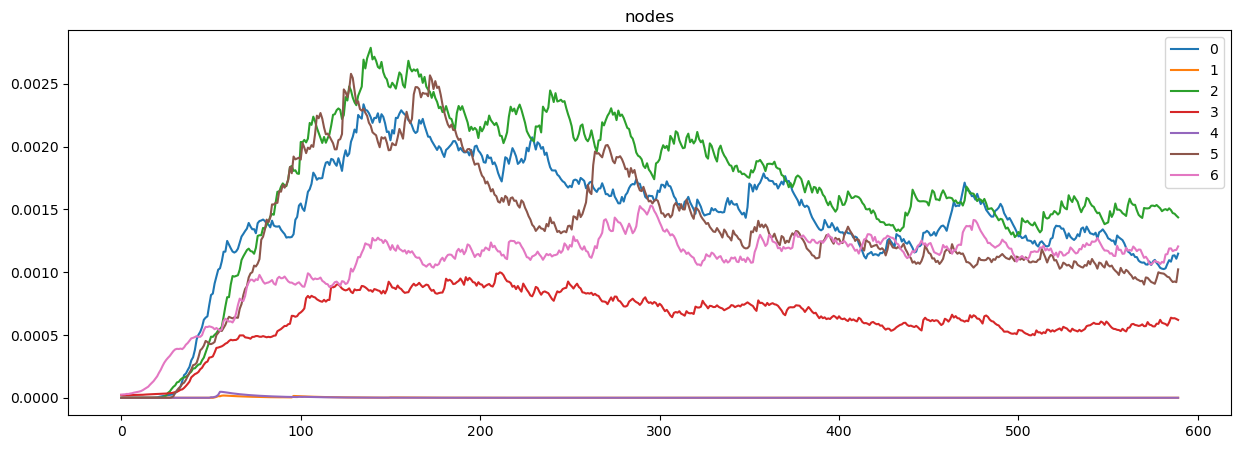

In [ ]:
#|eval: false
axes = subplots(figsize=(15,5))[1]
for i, k in enumerate(['nodes']): axes[i].title.set_text(k)
cbs[1].show(model.nodes, lambda x: x.abs().mean(-1), ax=axes[0])

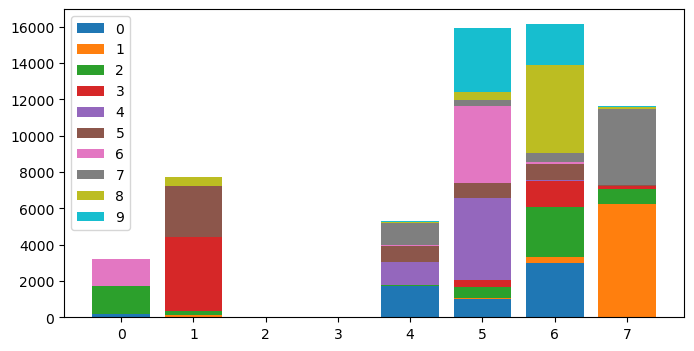

In [ ]:
#|eval: false
ax = subplots(figsize=(8,4))[1][0]
cbs[0].show(-1, ax=ax)